# Functions

### Loading Data

In [ ]:
import SimpleITK as sitk
import nibabel as nib
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt

def load_image(filepath, format=None):
    '''
    Formats: ["NIFTI", "MGH", "MHD", "NRRD", "AFNI", "DICOM"] //str
    '''
    
    ext = os.path.splitext(filepath)[-1].lower()
    
    if ext in ["*.nii", "*.nii.gz"] or format == "NIFTI":
        nifti_image = nib.load(filepath)
        return nifti_image.get_fdata(dtype=np.float32)
    
    if ext in [".mgh", ".mgz"] or format == "MGH":
        mgh_image = nib.load(filepath)
        return mgh_image.get_fdata(dtype=np.float32)
    
    if ext == ".mhd" or format == "MHD":
        mhd_image = sitk.ReadImage(filepath)
        return sitk.GetArrayFromImage(mhd_image).astype(np.float32)

    if ext == ".nrrd" or format == "NRRD":
        nrrd_image = sitk.ReadImage(filepath)
        return sitk.GetArrayFromImage(nrrd_image).astype(np.float32)
    
    if ext in [".head", ".brik"] or format == "AFNI":
        afni_image = nib.load(filepath)
        return afni_image.get_fdata(dtype=np.float32)
    
    if ext == ".dcm" or format == "DICOM" or os.path.isdir(filepath):
        return load_dicom(filepath)
    
    raise ValueError(f"Unsupported file format or file not recognized: {filepath}")

# def load_dicom(filepath):
#     if os.path.isdir(filepath):
#         files = [os.path.join(filepath, f) for f in os.listdir(filepath) if f.endswith('.dcm')]
#         slices = [pydicom.dcmread(f) for f in sorted(files, key=lambda x: pydicom.dcmread(x).InstanceNumber)]
#         image_array = np.stack([s.pixel_array for s in slices], axis=0).astype(np.float32)
#     else:
#         dicom_image = pydicom.dcmread(filepath)
#         image_array = dicom_image.pixel_array.astype(np.float32)
#     return image_array

def load_dicom(filepath):
    if os.path.isdir(filepath):
        # Get the list of DICOM files in the directory
        dicom_series_reader = sitk.ImageSeriesReader()
        dicom_series = dicom_series_reader.GetGDCMSeriesFileNames(filepath)
        dicom_series_reader.SetFileNames(dicom_series)
        
        # Read the DICOM series as a 3D image
        image = dicom_series_reader.Execute()
        
        # Convert the SimpleITK image to a NumPy array
        image_array = sitk.GetArrayFromImage(image).astype(np.float32)
    else:
        # Read a single DICOM file
        image = sitk.ReadImage(filepath)
        
        # Convert the SimpleITK image to a NumPy array
        image_array = sitk.GetArrayFromImage(image).astype(np.float32)
    
    return image_array


In [5]:
from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve
import cv2

# WINDOWING
def apply_window(image, window_level=None, window_width=None):
    min_val = np.min(image)
    max_val = np.max(image)
    
    # If window_level and window_width are not provided, use dynamic values
    if window_level is None:
        window_level = (min_val + max_val) / 2  # Center of the intensity range
    if window_width is None:
        window_width = max_val - min_val  # Full range of the intensities
    
    # Calculate the windowing bounds
    lower_bound = window_level - window_width / 2
    upper_bound = window_level + window_width / 2
    
    # Clip the image to the windowing range
    windowed_image = np.clip(image, lower_bound, upper_bound)
    
    # Normalize the image to the range [0, 1] for display purposes
    windowed_image = (windowed_image - lower_bound) / (upper_bound - lower_bound)
    
    return windowed_image

def smooth_image(image, sigma=1, strength = 1.0):
    return gaussian_filter(image, sigma=sigma) * strength

def sharpen_image(image, strength=1.0):
    # Define the Laplacian kernel (3x3 in 3 channels)
    laplacian_kernel = np.array([[[0, 0, 0],
                                  [0, -1, 0],
                                  [0, 0, 0]],
                                 [[0, -1, 0],
                                  [-1, 5 * strength, -1],
                                  [0, -1, 0]],
                                 [[0, 0, 0],
                                  [0, -1, 0],
                                  [0, 0, 0]]])

    # Apply the convolution operation to sharpen the image
    sharpened_image = convolve(image, laplacian_kernel)

    return sharpened_image

def reduce_noise(image, filter_type, size=3, sigma_color=0.05, sigma_spatial=15):
    """
    Parameters:
        image (numpy.ndarray): 3D image array.
        filter_type (str): Type of noise reduction filter ('Median' or 'Bilateral').
        size (int): Size of the median filter kernel (used for 'Median').
        sigma_color (float): Range variance for bilateral filter (used for 'Bilateral').
        sigma_spatial (float): Spatial variance for bilateral filter (used for 'Bilateral').
    """
    filtered_image = image.copy()
    
    if filter_type == 'Median':
        from scipy.ndimage import median_filter
        filtered_image = median_filter(filtered_image, size=size)
    elif filter_type == 'Bilateral':
        from skimage.restoration import denoise_bilateral
        filtered_image = denoise_bilateral(
            filtered_image,
            sigma_color=sigma_color,
            sigma_spatial=sigma_spatial,
            multichannel=False  # Assuming the image is grayscale or single-channel
        )
    else:
        raise ValueError(f"Unknown filter type: {filter_type}")
    
    return filtered_image

def normalize_image(image):
    image = np.array(image, dtype=np.float32)
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return normalized_image

def high_pass_filter_cv(image, sigma=1.0, strength=1.0):
    # Apply Gaussian blur using OpenCV
    low_pass = cv2.GaussianBlur(image, (0, 0), sigma)
    
    # High-pass filtering by subtracting the blurred image
    high_pass = image - low_pass
    
    # Apply strength factor and add it back to the original image
    sharpened_image = image + (high_pass * strength)
    return sharpened_image

# Usage

In [6]:
import os 
os.chdir(r"C:\Study\HIS 2\DICOM-Viewer-Features")


In [14]:
# dicom_image = load_image("C:\Study\HIS 2\series-000001\image-000001.dcm", ".dcm")
dicom_image = load_image("C:\Study\HIS 2\series-000001", ".dcm")
# dicom_image = load_image(r"../assets/data/nifti", ".NIFTI")
image = dicom_image

In [15]:
min_val = np.min(image)
max_val = np.max(image)
print(min_val, max_val)

0.0 5145.0


In [25]:
# # Apply windowing
# windowed_image = apply_window(dicom_image, 2000, 2000)
# image = windowed_image

In [24]:
# # Apply sharpening
# sharpened_image = sharpen_image(dicom_image, .8)
# image = sharpened_image

In [23]:
# # Apply sharpening
# smoothed_image = smooth_image(dicom_image, 1, 2)
# image = smoothed_image

In [22]:
# # Apply noise reduction
# smoothed_image = reduce_noise(dicom_image, 'Median')
# image = smoothed_image

In [27]:
# plt.figure(figsize=(10, 10))
# plt.imshow(image[70], cmap='gray')
# plt.title("Enhanced Image")
# plt.axis('off')
# plt.show()

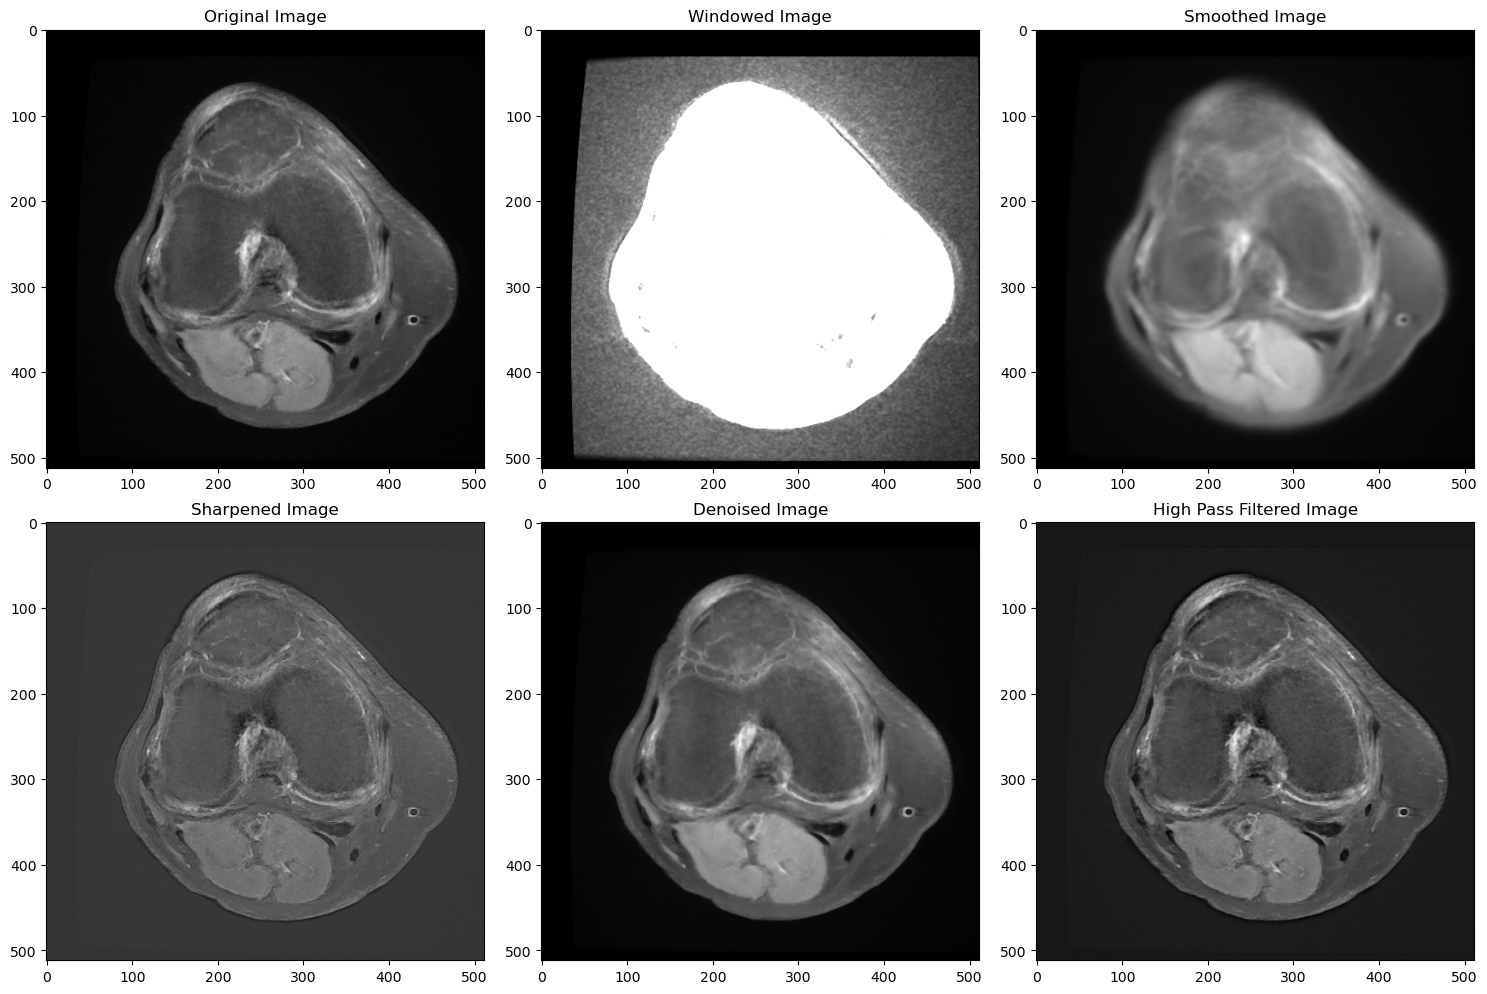

In [29]:

# Apply image enhancements
windowed_image = apply_window(image, window_level=100, window_width=200)  # Adjust window level and width
smoothed_image = smooth_image(image, sigma=2, strength=1.0)
sharpened_image = sharpen_image(image, strength=1.5)
denoised_image = reduce_noise(image, filter_type='Median', size=3)
normalized_image = normalize_image(image)
high_pass_filtered_image = high_pass_filter_cv(image, sigma=1.0, strength=1.5)

# Plot the original and enhanced images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(image[image.shape[0] // 2], cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 1].imshow(windowed_image[windowed_image.shape[0] // 2], cmap='gray')
axes[0, 1].set_title('Windowed Image')
axes[0, 2].imshow(smoothed_image[smoothed_image.shape[0] // 2], cmap='gray')
axes[0, 2].set_title('Smoothed Image')

axes[1, 0].imshow(sharpened_image[sharpened_image.shape[0] // 2], cmap='gray')
axes[1, 0].set_title('Sharpened Image')
axes[1, 1].imshow(denoised_image[denoised_image.shape[0] // 2], cmap='gray')
axes[1, 1].set_title('Denoised Image')
axes[1, 2].imshow(high_pass_filtered_image[high_pass_filtered_image.shape[0] // 2], cmap='gray')
axes[1, 2].set_title('High Pass Filtered Image')

plt.tight_layout()
plt.show()
